# SHAP
XGBoost Starter를 기반으로 SHAP을 적용하는 방법에 대해 기술

본 노트북 기반 시작 https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793

# Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os
import lime
import lime.lime_tabular

print('RAPIDS version',cudf.__version__)

RAPIDS version 22.06.00


In [2]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

# Process and Feature Engineer Train Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [3]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    #df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    # FILL NAN
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df

print('Reading train data...')
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
train = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [4]:
def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

train = process_and_feature_engineer(train)

shape after engineering (458913, 918)


In [5]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 918 features!


In [6]:
# Load Models
import xgboost as xgb

model = xgb.Booster()
model.load_model('result_xgboost-starter/XGB_v1_fold3.xgb')

# SHAP (SHapley Additive exPlanations)
섀플리 값(Shapley value)과 피처 간 독립성을 핵심 아이디어로 사용하는 XAI 기법
- 섀플리 값은 전체 성괄르 창출하는 데 각 참여자가 얼마나 공헌했는지 수치로 표현할 수 있다.
- 섀플리 값에 의하면, 각 사람의 기여도는 그 사람의 기여도를 제외했을 때 전체 성과의 변화 정도를 나타낼 수 있다.
- 예를 들어, A씨가 가지고 있는 주택이 강을 끼고 있기 때문에 집값이 높다고 추정된다면 강가로부터의 거리를 강제로 늘렸을 때 집값이 어떻게 변할지 예측한 다음, 이를 원래 집값에서 빼면 그 차이가 집값에 이바지하는 정도라고 추론하는 식

**pros**
- 데이터 수의 제곱에 비례해 계산량이 증가
- 기존의 데이터를 확고하게 믿고 해석하기에 outlier에 취약

In [7]:
train_df = train.iloc[:, 1:-1].to_pandas() # Customer_ID, target 제거 및 cudf -> pd로 변경

In [8]:
import shap
shap.initjs() # JS 로드

In [9]:
%%time
explaner = shap.TreeExplainer(model)
# shap_values = explaner.shap_values(train_df)
shap_values = explaner(train_df)

CPU times: user 1h 4min 8s, sys: 3.09 s, total: 1h 4min 11s
Wall time: 1min 41s


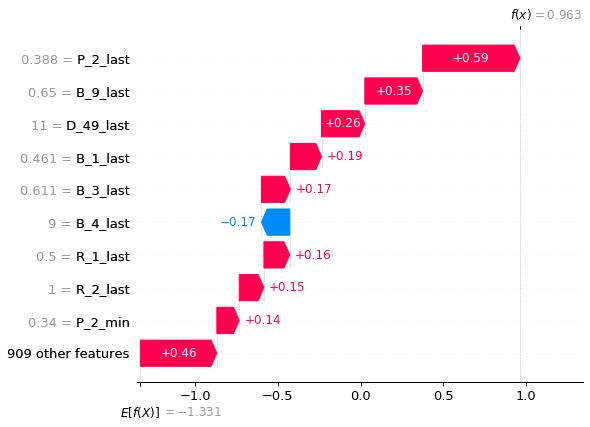

In [10]:
# 0번째 고객에 대한 SHAP 시각화
shap.plots.waterfall(shap_values[0])

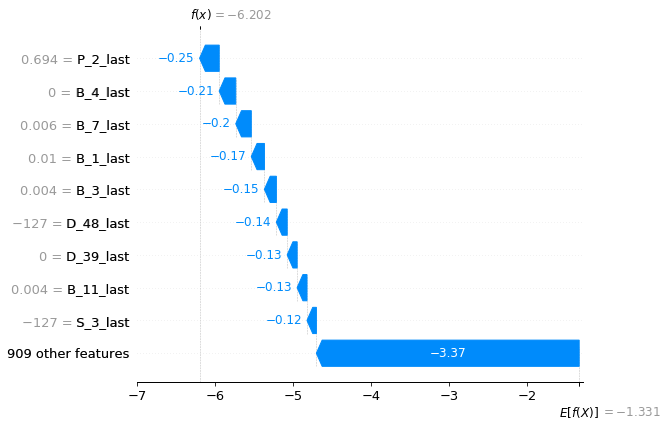

In [11]:
# 2번째 고객에 대한 SHAP 시각화
shap.plots.waterfall(shap_values[2])

In [12]:
# 단일 고객에 대한 시각화
shap.plots.force(shap_values[2])

In [17]:
%%time

# 100명의 고객에 대한 시각화
shap.plots.force(shap_values[:100])

CPU times: user 445 ms, sys: 11 ms, total: 456 ms
Wall time: 455 ms


In [27]:
num = 5000 # 얼마나 많은 고객을 볼건지, 많으면 시간이 오래 걸리므로 앞에서 5000명 선택

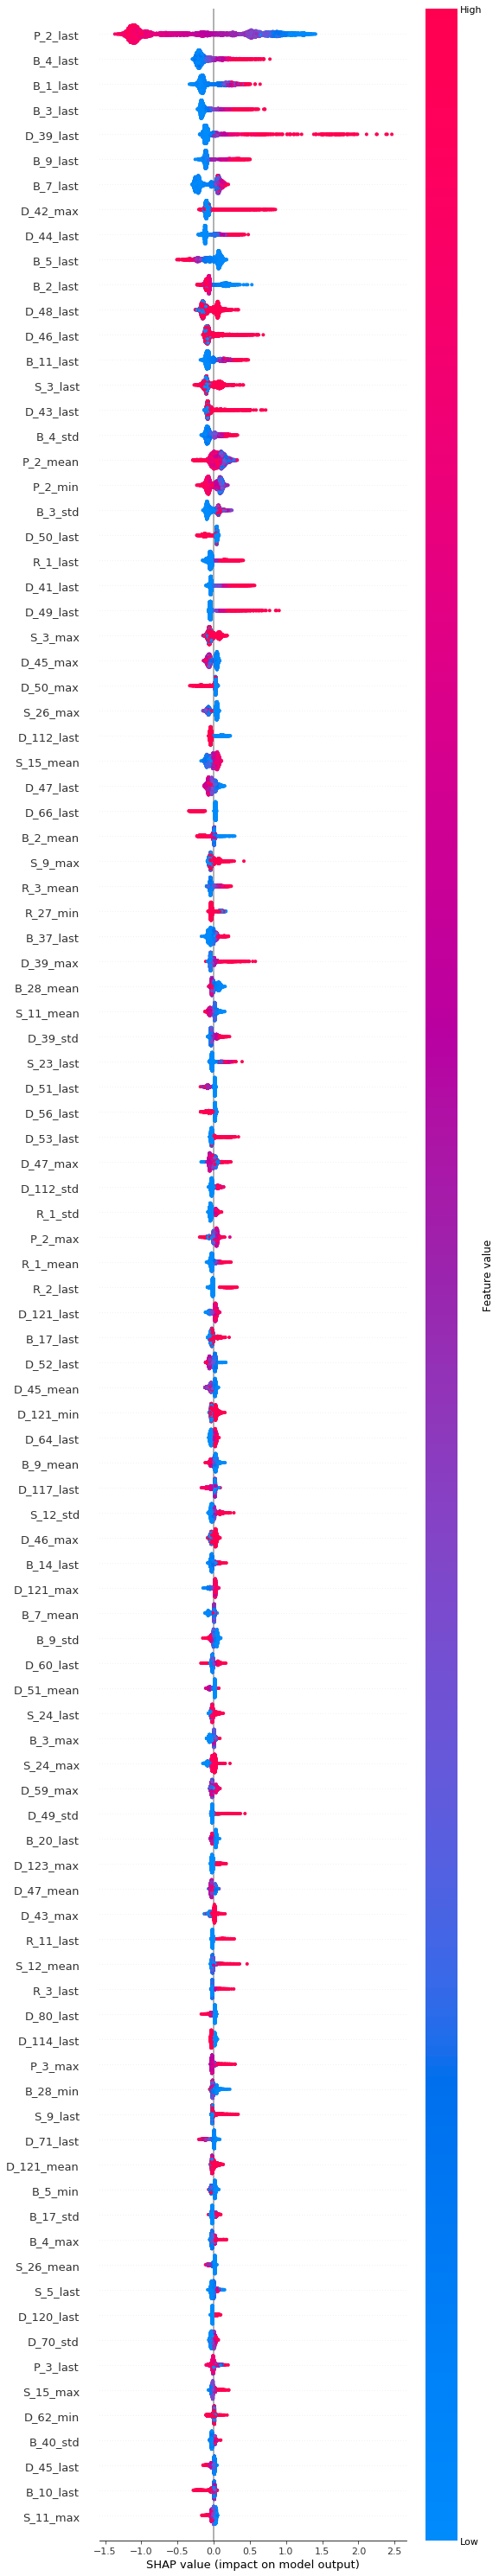

CPU times: user 7.92 s, sys: 4.18 s, total: 12.1 s
Wall time: 7.46 s


In [28]:
%%time
# 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
# 데이터의 수에 비례해 연산량이 늘어나므로 5,000명의 고객으로만 확인
# 엄연히 모든 데이터에 대해 수행해야하나 시간이 오래 걸림
shap.summary_plot(shap_values[:num], train_df.iloc[:num], max_display=100)

- 붉은 점은 그 지점에 해당하는 행 피처가 default를 결정하는데 큰 영향을 미침을 의미
- 푸른 점은 그 지점에 해당하는 행 피처가 default를 결정하는데 적은 영향을 미쳤다는 의미
- P_2_last, D_39_last의 분산이 크며 붉은 점도 집중되어 있음. => default를 결정하는데 큰 역할을 반영
- 그 외에도 D_48_last, D_42_max, D_46_last 등이 default를 결정하는데 역할을 미침

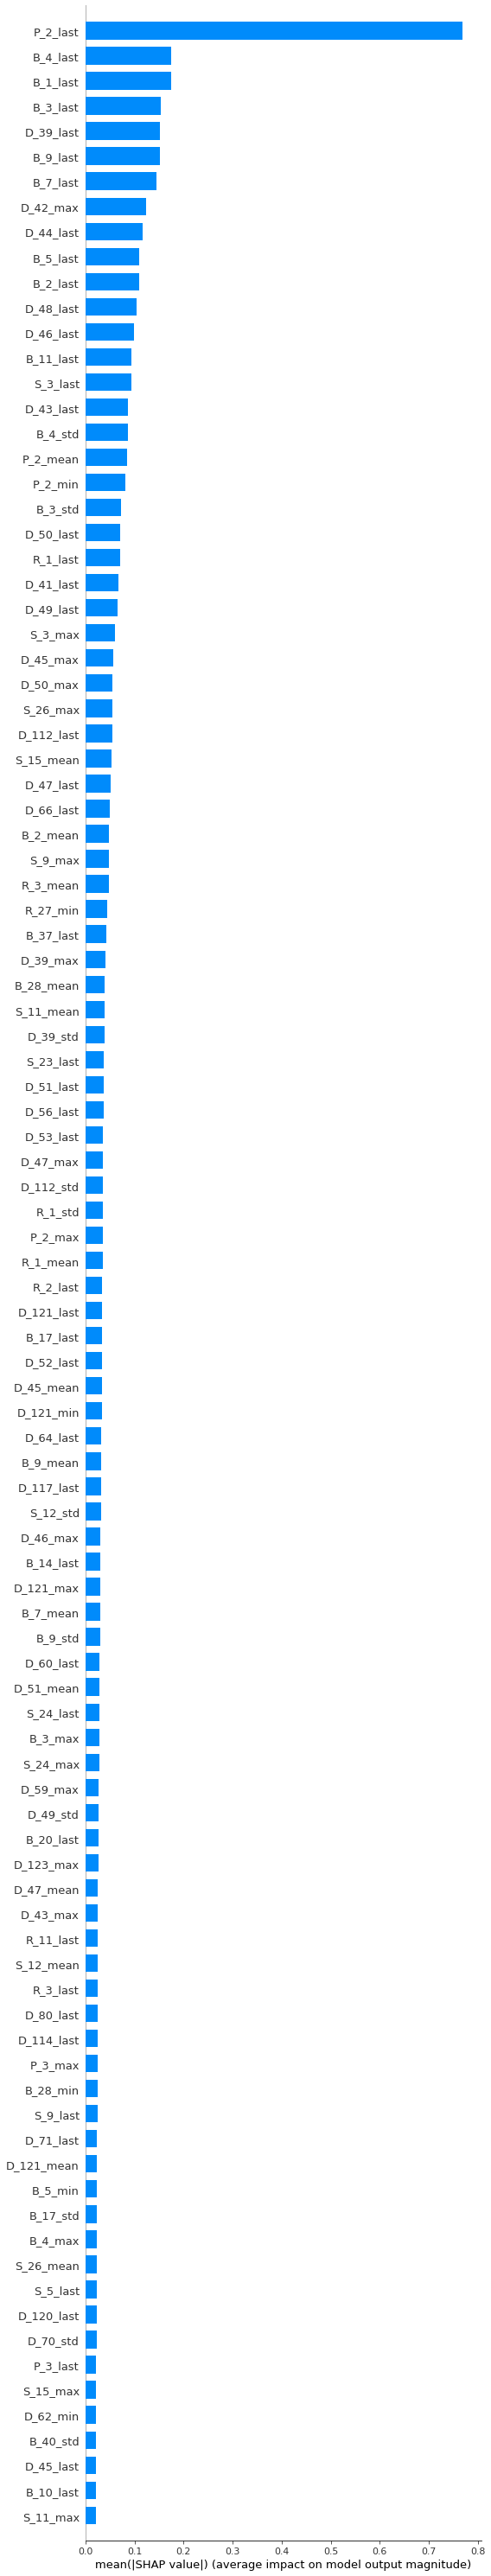

CPU times: user 1.15 s, sys: 452 ms, total: 1.6 s
Wall time: 1.17 s


In [25]:
%%time
# 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
# 위 그림의 bar plot 형태 시각화
shap.summary_plot(shap_values[:num], train_df.iloc[:num], plot_type='bar', max_display=100)

- 피쳐 중요도와 다른 결과를 보임
- 피처 중요도는 permutation 기법을 사용해 피처가 모델에 미치는 영향을 측정 => 데이터를 약간만 조작하면 되기에 계산 속도가 빠르지만 피처들이 서로 의존적일때는 결과가 왜곡될 수 있으며, 음의 영향력은 계산하지 않음 (즉, 에러가 높아지는 변인은 결과에 포함하지 않ㅇ음 왜냐면 모델이 학습할 때 음의 피처에 대해 학습을 의도적으로 무시하기 때문이다.) 따라서 실제 영향력보다 특정 피처의 가치가 높게 측정될 수 있음
- 섀플리 값은 피처들이 서로 영향을 미칠 가능성을 고려. 피처 간의 의존성을 고려하고 음의 영향력을 계산할 수 있다.

#### 영향도에 따른 feature order 생성

In [34]:
all_cols = [c for c in list(train.columns) if c not in ['customer_ID','S_2']]
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
num_features = [col for col in all_cols if col not in cat_features]

In [66]:
# https://github.com/slundberg/shap/blob/45b85c1837283fdaeed7440ec6365a886af4a333/shap/plots/_beeswarm.py#L539
sort_inds = np.argsort(-np.abs(shap_values[:num].values.sum(0)))
shap_list = np.sort(np.abs(shap_values[:num].values.sum(0)))[::-1]
feature_order = np.array(shap_values[:num].feature_names)[sort_inds]

In [90]:
# 아무런 영향이 없는 feature 수
zero_shap_feature_index = sum(shap_list[sort_inds]!=0)

In [92]:
todrop_0 = []
for col in list(feature_order[zero_shap_feature_index:]):
    col_name = '_'.join(col.split('_')[:2])
# 실제 모델에 넣을 때 고려해야하는 피쳐들, agg 전에 특정 피쳐에 대해 전부 제거하거나 min, std를 아예 안쓰는 경우 등등
# 사실 그렇게 모델링 된 결과를 이용해서 분석을 수행해야하는데 일단 테스트이므로 무식하게 진행중
#     if col_name in drop1:
#         continue
#     if '_min' in col or '_std' in col:
#         continue
#     if '_last' in col and col_name in num_features:
#         continue
    todrop_0.append(col)

In [94]:
todrop_0, len(todrop_0)

(['R_4_max',
  'D_137_max',
  'D_126_count',
  'R_4_min',
  'D_63_count',
  'R_10_min',
  'D_137_last',
  'D_64_count',
  'S_6_min',
  'D_137_min',
  'D_66_count',
  'D_68_count',
  'S_6_max',
  'D_82_min',
  'D_117_count',
  'R_2_max',
  'R_8_min',
  'R_11_min',
  'D_79_min',
  'D_139_max',
  'D_139_min',
  'R_7_min',
  'D_120_count',
  'D_143_max',
  'D_81_last',
  'B_38_count',
  'D_116_count',
  'R_2_min',
  'D_140_max',
  'D_138_min',
  'D_143_last',
  'D_109_last',
  'S_18_min',
  'R_13_min',
  'D_94_min',
  'D_94_std',
  'D_93_max',
  'D_93_min',
  'D_93_mean',
  'D_92_max',
  'D_92_min',
  'R_23_last',
  'R_23_max',
  'R_23_min',
  'R_23_std',
  'R_22_max',
  'R_22_min',
  'D_89_min',
  'B_33_max',
  'D_94_max',
  'B_33_min',
  'D_94_last',
  'R_24_max',
  'D_111_min',
  'D_109_max',
  'D_111_last',
  'D_109_min',
  'B_39_min',
  'D_108_last',
  'D_108_min',
  'D_103_last',
  'D_103_max',
  'D_103_min',
  'D_96_max',
  'D_96_min',
  'R_25_max',
  'R_25_min',
  'R_25_std',
  'R_

SHAP이 조금만(1) 큰 애들까지 삭제

In [77]:
# 아무런 영향이 없는 feature 수
# 아까 설명할때 잘못이야기 했구나 5xx개가 아니라 915-5xx 개였음
sum(shap_list<1)

350

In [86]:
todrop_1 = []
for col in list(feature_order[sum(shap_list<1):]):
    col_name = '_'.join(col.split('_')[:2])
#     if col_name in drop1:
#         continue
#     if '_min' in col or '_std' in col:
#         continue
#     if '_last' in col and col_name in num_features:
#         continue
    todrop_1.append(col)

In [95]:
todrop_1, len(todrop_1)

(['D_119_last',
  'D_79_last',
  'B_39_mean',
  'B_15_max',
  'B_32_mean',
  'D_41_mean',
  'D_141_max',
  'R_27_mean',
  'S_9_mean',
  'D_70_last',
  'B_19_mean',
  'D_131_max',
  'D_138_last',
  'D_111_mean',
  'D_134_last',
  'D_74_max',
  'R_15_mean',
  'D_39_mean',
  'S_11_max',
  'R_7_mean',
  'R_9_max',
  'R_26_last',
  'B_17_mean',
  'D_131_last',
  'B_30_last',
  'B_26_last',
  'B_33_last',
  'D_61_mean',
  'D_125_mean',
  'B_38_nunique',
  'S_27_last',
  'B_36_mean',
  'D_144_last',
  'D_84_last',
  'B_26_mean',
  'S_25_mean',
  'B_4_mean',
  'R_6_mean',
  'B_42_max',
  'S_6_last',
  'D_105_mean',
  'D_133_mean',
  'R_14_max',
  'B_18_max',
  'P_3_mean',
  'D_126_nunique',
  'B_19_last',
  'D_96_last',
  'S_13_mean',
  'S_19_mean',
  'R_4_last',
  'D_143_mean',
  'S_15_last',
  'D_145_mean',
  'D_86_last',
  'D_63_last',
  'B_29_last',
  'D_54_last',
  'D_106_max',
  'D_104_last',
  'B_29_max',
  'B_39_last',
  'D_69_last',
  'D_94_mean',
  'P_3_last',
  'D_83_max',
  'R_7_ma